In [1]:
import torch
import torchvision
import os

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import re

from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid


from sklearn.preprocessing import LabelEncoder
from torchvision import transforms as Transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from torchvision.models import mobilenet_v3_small
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import mimetypes
import argparse
import imutils

In [2]:
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

BASE_OUTPUT = "output"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])
ALL_PATHS = os.path.sep.join(["image_paths.txt"])
PREDICT_PATHS = os.path.sep.join(["predict_output", "bbox.txt"])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

INIT_LR = 0.0064
NUM_EPOCHS = 30
BATCH_SIZE = 16

LABELS = 1.0
BBOX = 1.0

In [3]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# PIN_MEMORY = True if DEVICE == "cuda" else False

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

# INIT_LR = 1e-4
# NUM_EPOCHS = 15
# BATCH_SIZE = 16

# LABELS = 1.0
# BBOX = 1.0

In [4]:
class CustomTensorDataset(Dataset):
	# initialize the constructor
	def __init__(self, tensors, transforms=None):
		self.tensors = tensors
		self.transforms = transforms
	def __getitem__(self, index):
		# grab the image, label, and its bounding box coordinates
		image = self.tensors[0][index]
		label = self.tensors[1][index]
		bbox = self.tensors[2][index]
		# transpose the image such that its channel dimension becomes
		# the leading one
		image = image.permute(2, 0, 1)
		# check to see if we have any image transformations to apply
		# and if so, apply them
		if self.transforms:
			image = self.transforms(image)
		# return a tuple of the images, labels, and bounding
		# box coordinates
		return (image, label, bbox)
	def __len__(self):
		# return the size of the dataset
		return self.tensors[0].size(0)

In [5]:
class ObjectDetector(Module):
	def __init__(self, baseModel, numClasses):
		super(ObjectDetector, self).__init__()
		# initialize the base model and the number of classes
		self.baseModel = baseModel
		self.numClasses = numClasses
		# build the regressor head for outputting the bounding box
		# coordinates
		self.regressor = Sequential(
			Linear(baseModel.fc.in_features, 128),
			ReLU(),
			Linear(128, 64),
			ReLU(),
			Linear(64, 32),
			ReLU(),
			Linear(32, 4),
			Sigmoid()
		)
		# build the classifier head to predict the class labels
		self.classifier = Sequential(
			Linear(baseModel.fc.in_features, 512),
			ReLU(),
			Dropout(),
			Linear(512, 512),
			ReLU(),
			Dropout(),
			Linear(512, self.numClasses)
		)
		# set the classifier of our base model to produce outputs
		# from the last convolution block
		self.baseModel.fc = Identity()
	def forward(self, x):
		# pass the inputs through the base model and then obtain
		# predictions from two different branches of the network
		features = self.baseModel(x)
		bboxes = self.regressor(features)
		classLogits = self.classifier(features)


		# return the outputs as a tuple
		return (bboxes,classLogits)

[INFO] loading dataset...
[INFO] total training samples: 587...
[INFO] total test samples: 147...
[INFO] saving testing image paths...
[INFO] saving image paths...
[INFO] training the network...


  3%|▎         | 1/30 [01:31<44:05, 91.23s/it]

587.0 587
147.0 147
[INFO] EPOCH: 1/30
Train loss: 0.039700, Train accuracy: 1.0000
Val loss: 0.019317, Val accuracy: 1.0000


  7%|▋         | 2/30 [03:07<44:04, 94.45s/it]

587.0 587
147.0 147
[INFO] EPOCH: 2/30
Train loss: 0.029385, Train accuracy: 1.0000
Val loss: 0.016003, Val accuracy: 1.0000


 10%|█         | 3/30 [04:45<43:06, 95.79s/it]

587.0 587
147.0 147
[INFO] EPOCH: 3/30
Train loss: 0.023947, Train accuracy: 1.0000
Val loss: 0.013703, Val accuracy: 1.0000


 13%|█▎        | 4/30 [06:19<41:15, 95.20s/it]

587.0 587
147.0 147
[INFO] EPOCH: 4/30
Train loss: 0.021727, Train accuracy: 1.0000
Val loss: 0.013512, Val accuracy: 1.0000


 17%|█▋        | 5/30 [07:53<39:25, 94.60s/it]

587.0 587
147.0 147
[INFO] EPOCH: 5/30
Train loss: 0.019307, Train accuracy: 1.0000
Val loss: 0.011654, Val accuracy: 1.0000


 20%|██        | 6/30 [09:25<37:31, 93.82s/it]

587.0 587
147.0 147
[INFO] EPOCH: 6/30
Train loss: 0.017863, Train accuracy: 1.0000
Val loss: 0.013072, Val accuracy: 1.0000


 23%|██▎       | 7/30 [11:00<36:05, 94.17s/it]

587.0 587
147.0 147
[INFO] EPOCH: 7/30
Train loss: 0.017304, Train accuracy: 1.0000
Val loss: 0.013599, Val accuracy: 1.0000


 27%|██▋       | 8/30 [12:38<35:01, 95.52s/it]

587.0 587
147.0 147
[INFO] EPOCH: 8/30
Train loss: 0.016451, Train accuracy: 1.0000
Val loss: 0.011849, Val accuracy: 1.0000


 30%|███       | 9/30 [14:23<34:28, 98.50s/it]

587.0 587
147.0 147
[INFO] EPOCH: 9/30
Train loss: 0.015771, Train accuracy: 1.0000
Val loss: 0.012550, Val accuracy: 1.0000


 33%|███▎      | 10/30 [16:05<33:09, 99.50s/it]

587.0 587
147.0 147
[INFO] EPOCH: 10/30
Train loss: 0.015499, Train accuracy: 1.0000
Val loss: 0.011881, Val accuracy: 1.0000


 37%|███▋      | 11/30 [17:55<32:31, 102.70s/it]

587.0 587
147.0 147
[INFO] EPOCH: 11/30
Train loss: 0.014705, Train accuracy: 1.0000
Val loss: 0.012208, Val accuracy: 1.0000


 40%|████      | 12/30 [19:54<32:19, 107.75s/it]

587.0 587
147.0 147
[INFO] EPOCH: 12/30
Train loss: 0.015037, Train accuracy: 1.0000
Val loss: 0.012965, Val accuracy: 1.0000


 43%|████▎     | 13/30 [22:02<32:16, 113.89s/it]

587.0 587
147.0 147
[INFO] EPOCH: 13/30
Train loss: 0.014580, Train accuracy: 1.0000
Val loss: 0.013341, Val accuracy: 1.0000


 47%|████▋     | 14/30 [24:14<31:49, 119.32s/it]

587.0 587
147.0 147
[INFO] EPOCH: 14/30
Train loss: 0.014546, Train accuracy: 1.0000
Val loss: 0.014347, Val accuracy: 1.0000


 50%|█████     | 15/30 [25:39<27:12, 108.86s/it]

587.0 587
147.0 147
[INFO] EPOCH: 15/30
Train loss: 0.014432, Train accuracy: 1.0000
Val loss: 0.012404, Val accuracy: 1.0000


 53%|█████▎    | 16/30 [27:33<25:45, 110.41s/it]

587.0 587
147.0 147
[INFO] EPOCH: 16/30
Train loss: 0.014079, Train accuracy: 1.0000
Val loss: 0.012490, Val accuracy: 1.0000


 57%|█████▋    | 17/30 [29:48<25:31, 117.79s/it]

587.0 587
147.0 147
[INFO] EPOCH: 17/30
Train loss: 0.013733, Train accuracy: 1.0000
Val loss: 0.012417, Val accuracy: 1.0000


 60%|██████    | 18/30 [32:07<24:51, 124.33s/it]

587.0 587
147.0 147
[INFO] EPOCH: 18/30
Train loss: 0.012736, Train accuracy: 1.0000
Val loss: 0.012070, Val accuracy: 1.0000


 63%|██████▎   | 19/30 [34:17<23:05, 125.93s/it]

587.0 587
147.0 147
[INFO] EPOCH: 19/30
Train loss: 0.012805, Train accuracy: 1.0000
Val loss: 0.013276, Val accuracy: 1.0000


 67%|██████▋   | 20/30 [36:45<22:06, 132.63s/it]

587.0 587
147.0 147
[INFO] EPOCH: 20/30
Train loss: 0.012763, Train accuracy: 1.0000
Val loss: 0.012635, Val accuracy: 1.0000


 70%|███████   | 21/30 [39:05<20:13, 134.89s/it]

587.0 587
147.0 147
[INFO] EPOCH: 21/30
Train loss: 0.012755, Train accuracy: 1.0000
Val loss: 0.012933, Val accuracy: 1.0000


 73%|███████▎  | 22/30 [41:24<18:08, 136.05s/it]

587.0 587
147.0 147
[INFO] EPOCH: 22/30
Train loss: 0.012414, Train accuracy: 1.0000
Val loss: 0.011892, Val accuracy: 1.0000


 77%|███████▋  | 23/30 [43:32<15:35, 133.67s/it]

587.0 587
147.0 147
[INFO] EPOCH: 23/30
Train loss: 0.012769, Train accuracy: 1.0000
Val loss: 0.011862, Val accuracy: 1.0000


 80%|████████  | 24/30 [46:08<14:01, 140.29s/it]

587.0 587
147.0 147
[INFO] EPOCH: 24/30
Train loss: 0.012323, Train accuracy: 1.0000
Val loss: 0.012394, Val accuracy: 1.0000


 83%|████████▎ | 25/30 [48:34<11:50, 142.08s/it]

587.0 587
147.0 147
[INFO] EPOCH: 25/30
Train loss: 0.011933, Train accuracy: 1.0000
Val loss: 0.012086, Val accuracy: 1.0000


 87%|████████▋ | 26/30 [51:02<09:34, 143.73s/it]

587.0 587
147.0 147
[INFO] EPOCH: 26/30
Train loss: 0.012045, Train accuracy: 1.0000
Val loss: 0.013696, Val accuracy: 1.0000


 90%|█████████ | 27/30 [53:02<06:49, 136.56s/it]

587.0 587
147.0 147
[INFO] EPOCH: 27/30
Train loss: 0.011682, Train accuracy: 1.0000
Val loss: 0.013477, Val accuracy: 1.0000


 93%|█████████▎| 28/30 [54:42<04:11, 125.72s/it]

587.0 587
147.0 147
[INFO] EPOCH: 28/30
Train loss: 0.011668, Train accuracy: 1.0000
Val loss: 0.011354, Val accuracy: 1.0000


 97%|█████████▋| 29/30 [56:48<02:05, 125.69s/it]

587.0 587
147.0 147
[INFO] EPOCH: 29/30
Train loss: 0.011785, Train accuracy: 1.0000
Val loss: 0.012523, Val accuracy: 1.0000


100%|██████████| 30/30 [59:07<00:00, 118.25s/it]

587.0 587
147.0 147
[INFO] EPOCH: 30/30
Train loss: 0.011645, Train accuracy: 1.0000
Val loss: 0.012019, Val accuracy: 1.0000
[INFO] total time taken to train the model: 3547.71s
[INFO] saving object detector model...


[INFO] saving label encoder...


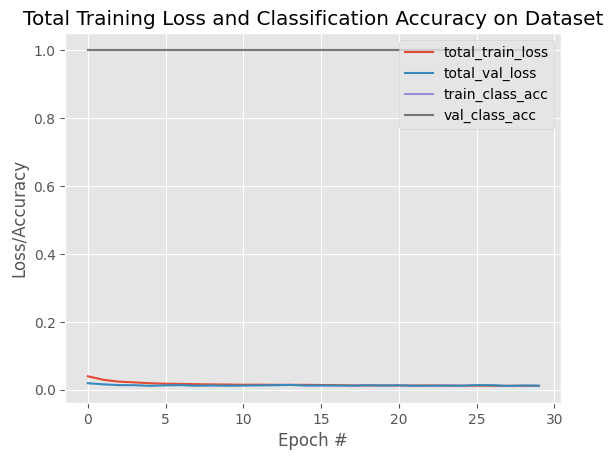

In [6]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []


# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
	# load the contents of the current CSV annotations file
	rows = open(csvPath).read().strip().split("\n")
	# loop over the rows
	for row in rows:
		# break the row into the filename, bounding box coordinates,
		# and class label
		row = row.split(",")


		if len(row) > 8 :
			label = row[10]
			parts = label.split('[')
			label_value = parts[1].split('"')[1]
			
			filename = row[3]
			parts2 = filename.split("/")
			imgFile = "/".join(parts2[4:])
			id = row[4]
			if(id == '3950'):
				continue
			startX = row[5]
			match = re.search(r'[-+]?\d*\.\d+|\d+', startX)
			x_value = match.group(0)
			startY = row[6]
			match2 = re.search(r'[-+]?\d*\.\d+|\d+', startY)
			y_value = match2.group(0)
			endX = row[7]
			match3 = re.search(r'[-+]?\d*\.\d+|\d+', endX)
			x_end = match3.group(0)
			endY = row[8]
			match4 = re.search(r'[-+]?\d*\.\d+|\d+', endY)
			y_end = match4.group(0)
			imagePath = os.path.sep.join([IMAGES_PATH, label_value,
			imgFile])
			image = cv2.imread(imagePath)
			(h, w) = image.shape[:2]
			startX = (float(x_value) / 100)
			startY = (float(y_value) / 100)
			endX = ((float(x_end) + float(x_value)) / 100)
			endY = ((float(y_end) + float(y_value)) / 100)
			image = cv2.imread(imagePath)
			image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
			image = cv2.resize(image, (224, 224))
			data.append(image)
			labels.append(label_value)
			bboxes.append((startX, startY, endX, endY))
			imagePaths.append(imagePath)
			

labels_test = labels
image_test = imagePaths
data_test = data
bbox_test = bboxes
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# convert NumPy arrays to PyTorch tensors
(trainImages, testImages) = torch.tensor(trainImages),\
	torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),\
	torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),\
	torch.tensor(testBBoxes)
# define normalization transforms
transforms = Transforms.Compose([
	Transforms.ToPILImage(),
	Transforms.ToTensor(),
	Transforms.Normalize(mean=MEAN, std=STD)
])


# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),
	transforms= transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),
	transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE
# create data loaders
trainLoader = DataLoader(trainDS, batch_size= BATCH_SIZE,
	shuffle=True, pin_memory= PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size= BATCH_SIZE, pin_memory= PIN_MEMORY)


# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

trainPaths_str = np.array(trainPaths, dtype='<U114')
testPaths_str = np.array(testPaths, dtype='<U114')

allPaths = np.concatenate((trainPaths_str, testPaths_str))

print("[INFO] saving image paths...")
f = open(ALL_PATHS, "w")
f.write("\n".join(allPaths))
f.close()
# load the ResNet50 network
resnet = resnet50(weights= 'DEFAULT')
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
	param.requires_grad = False

# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
# print(objectDetector)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	objectDetector.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (images, labels, bboxes) in trainLoader:
		# send the input to the device
		(images, labels, bboxes) = (images.to(DEVICE),
			labels.to(DEVICE), bboxes.to(DEVICE))
		# perform a forward pass and calculate the training loss
		predictions = objectDetector(images)
		bboxLoss = bboxLossFunc(predictions[0], bboxes)
		classLoss = classLossFunc(predictions[1], labels)
		totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
		
		

		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		totalLoss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += totalLoss
		trainCorrect += (predictions[1].argmax(1) == labels).type(
			torch.float).sum().item()
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		objectDetector.eval()
		# loop over the validation set
		for (images, labels, bboxes) in testLoader:
			# send the input to the device
			(images, labels, bboxes) = (images.to(DEVICE),
				labels.to(DEVICE), bboxes.to(DEVICE))
			# make the predictions and calculate the validation loss
			predictions = objectDetector(images)
			bboxLoss = bboxLossFunc(predictions[0], bboxes)
			classLoss = classLossFunc(predictions[1], labels)
			totalLoss = (BBOX * bboxLoss) + \
				(LABELS * classLoss)
			totalValLoss += totalLoss
			# calculate the number of correct predictions
			valCorrect += (predictions[1].argmax(1) == labels).type(
				torch.float).sum().item()
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	print(trainCorrect, len(trainDS))
	print(valCorrect, len(testDS))
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(testDS)
	# update our training history
	H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_class_acc"].append(trainCorrect)
	H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_class_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
		avgValLoss, valCorrect))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

In [7]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image paths")
# args = vars(ap.parse_args())
# # determine the input file type, but assume that we're working with
# # single input image
# filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = open("image_paths.txt").read().strip().split("\n")
# if the file type is a text file, then we need to process *multiple*
# images
# if "text/plain" == filetype:
# 	# load the image paths in our testing file
# 	imagePaths = open(args["input"]).read().strip().split("\n")

print("[INFO] loading object detector...")
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()
le = pickle.loads(open(LE_PATH, "rb").read())
# define normalization transforms
# transforms = transforms.Compose([
# 	transforms.ToPILImage(),
# 	transforms.ToTensor(),
# 	transforms.Normalize(mean=MEAN, std=STD)
# ])
bbox_result = []
data_image = []
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	# load the image, copy it, swap its colors channels, resize it, and
	# bring its channel dimension forward
	image_data = cv2.imread(imagePath)
	image = cv2.imread(imagePath)
	orig = image.copy()
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (256, 256))
	image = image.transpose((2, 0, 1))
	# convert image to PyTorch tensor, normalize it, flash it to the
	# current device, and add a batch dimension
	image = torch.from_numpy(image)
	image = transforms(image).to(DEVICE)
	image = image.unsqueeze(0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
	i = labelPreds.argmax(dim=-1).cpu()
	label = le.inverse_transform(i)[0]
	# resize the original image such that it fits on our screen, and
	# grab its dimensions
	orig = imutils.resize(orig, width=300)
	(h, w) = orig.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# print(startX,startY,endX,endY)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(orig, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	bboxes = boxPreds[0].detach().cpu().numpy()
	bboxes_str = np.array2string(bboxes)
	bbox_result.append(bboxes_str)
	data_image.append(image_data)
	# show the output image 
	# cv2.imshow("Output", orig)
	# cv2.waitKey(0)

f = open(PREDICT_PATHS, "w")
f.write("\n".join(bbox_result))
f.close()

with open(PREDICT_PATHS, "r") as file:
    content = file.read()

content = content.replace("[", "").replace("]", "")

with open(PREDICT_PATHS, "w") as file:
    file.write(content)
	

[INFO] loading object detector...


In [8]:
# # loop over all CSV files in the annotations directory
# for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
# 	# load the contents of the current CSV annotations file
# 	rows = open(csvPath).read().strip().split("\n")
# 	# loop over the rows
# 	for row in rows:
# 		# break the row into the filename, bounding box coordinates,
# 		# and class label
# 		row = row.split(",")


# 		if len(row) > 8 :
# 			label = row[10]
# 			parts = label.split('[')
# 			label_value = parts[1].split('"')[1]
			
# 			filename = row[3]
# 			parts2 = filename.split("/")
# 			imgFile = "/".join(parts2[4:])
# 			id = row[4]
# 			if(id == '3950'):
# 				continue
# 			startX = row[5]
# 			match = re.search(r'[-+]?\d*\.\d+|\d+', startX)
# 			x_value = match.group(0)
# 			startY = row[6]
# 			match2 = re.search(r'[-+]?\d*\.\d+|\d+', startY)
# 			y_value = match2.group(0)
# 			endX = row[7]
# 			match3 = re.search(r'[-+]?\d*\.\d+|\d+', endX)
# 			x_end = match3.group(0)
# 			endY = row[8]
# 			match4 = re.search(r'[-+]?\d*\.\d+|\d+', endY)
# 			y_end = match4.group(0)
# 			imagePath = os.path.sep.join([IMAGES_PATH, label_value,
# 			imgFile])
# 			image = cv2.imread(imagePath)
# 			(h, w) = image.shape[:2]
# 			startX = (float(x_value) / 100) * 256
# 			startY = (float(y_value) / 100) * 256
# 			endX = ((float(x_end) + float(x_value)) / 100) * 256
# 			endY = ((float(y_end) + float(y_value)) / 100) * 256
# 			image = cv2.imread(imagePath)
# 			# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 			image = cv2.resize(image, (256, 256))
# 			data.append(image)
# 			labels.append(label_value)
# 			bboxes.append((startX, startY, endX, endY))
# 			imagePaths.append(imagePath)
			
			

In [9]:
# # convert the data, class labels, bounding boxes, and image paths to
# # NumPy arrays
# data = np.array(data, dtype="float32")
# labels = np.array(labels)
# bboxes = np.array(bboxes, dtype="float32")
# imagePaths = np.array(imagePaths)
# # perform label encoding on the labels
# le = LabelEncoder()
# labels = le.fit_transform(labels)

In [10]:
with open(PREDICT_PATHS, "r") as file:
    lines = file.readlines()

with open(ALL_PATHS, "r") as file:
    liness = file.readlines()

bbox_array = []
path_array = []

for line in lines:
    bbox_values = line.split()
    bbox_values = [float(value) for value in bbox_values]
    (x1,y1,x2,y2) = bbox_values
    bbox_array.append((x1,y1,x2,y2))

for liness in liness:
    path_values = liness.split()
    path_array.append(path_values)

# print(bbox_array)
# print(bbox_test)


path_arrays = ([item for sublist in path_array for item in sublist])
# print(path_arrays)
# print(image_test)

for i in range(len(data_image)):
    image = data_image[i]
    label = labels_test[i]
    bbox = bbox_array[i]
    imagePath = path_arrays[i]
    imageShape = cv2.imread(imagePath)
    (h, w) = imageShape.shape[:2]
    

    # Draw bounding box on the image
    startX, startY, endX, endY = bbox
    # print(startX,startY,endX,endY)
    startX = startX * w
    startY = startY * h
    endX = endX * w
    endY = endY * h
    # print(startX,startY,endX,endY)

    crop_path = os.path.join('crop', os.path.basename(imagePath))
    crop_image = image[int(startY):int(endY), int(startX):int(endX)]
    cv2.imwrite(crop_path, crop_image)


    cv2.rectangle(image, (int(startX), int(startY)), (int(endX), int(endY)), (0, 255, 0), 3)
    output_path = os.path.join('gambar', os.path.basename(imagePath))
    cv2.imwrite(output_path, image)





In [11]:
directory = "C:/Users/ASUS/Documents/LatihanData/dead_chicken/images"
output_file = "C:/Users/ASUS/Documents/LatihanData/list_dead.txt"
print(imagePaths)
# Memeriksa apakah direktori ada
if os.path.exists(directory):
    # Memeriksa apakah direktori adalah sebuah direktori
    if os.path.isdir(directory):
        # Mendapatkan daftar file dalam direktori
        files = os.listdir(directory)
        
        # Memfilter hanya file dengan ekstensi gambar
        image_files = [file for file in files if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        # Menuliskan nama semua file gambar ke dalam file txt
        with open(output_file, 'w') as f:
            for image_file in image_files:
                image_dead = os.path.join('dead_chicken\images', image_file)
                f.write(image_dead + '\n')
                
    else:
        print("Path bukan direktori.")
else:
    print("Path tidak ditemukan.")

['dataset\\images\\chicken\\1db97a01-60010-1670724835.png', 'dataset\\images\\chicken\\a4e42f49-60010-1671179498.png', 'dataset\\images\\chicken\\0c2ae7a4-60010-1670840908.png', 'dataset\\images\\chicken\\8f0120c3-60010-1671526813.png', 'dataset\\images\\chicken\\19e404cf-60010-1670806980.png', 'dataset\\images\\chicken\\3a71351e-60010-1671615634.png', 'dataset\\images\\chicken\\ecbeca9b-60010-1670724836.png', 'dataset\\images\\chicken\\74c607da-60010-1671527849.png', 'dataset\\images\\chicken\\8da079e4-60010-1670636695.png', 'dataset\\images\\chicken\\8756d357-60010-1670933753.png', 'dataset\\images\\chicken\\e35f0df8-60010-1670656648.png', 'dataset\\images\\chicken\\81e9ab89-60010-1671528566.png', 'dataset\\images\\chicken\\d96906d8-60010-1671111643.png', 'dataset\\images\\chicken\\3d85d518-60010-1670724845.png', 'dataset\\images\\chicken\\abdf397f-60010-1671528111.png', 'dataset\\images\\chicken\\57f93ea4-60010-1671526674.png', 'dataset\\images\\chicken\\ec322a1b-60010-1670724832.pn

In [12]:
# determine the input file type, but assume that we're working with
# single input image
# filetype = mimetypes.guess_type(args["input"])[0]
predictImage = open("list_dead.txt").read().strip().split("\n")
# if the file type is a text file, then we need to process *multiple*
# images
# if "text/plain" == filetype:
# 	# load the image paths in our testing file
# 	imagePaths = open(args["input"]).read().strip().split("\n")
	
# load our object detector, set it evaluation mode, and label
# encoder from disk
print("[INFO] loading object detector...")
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()
le = pickle.loads(open(LE_PATH, "rb").read())
# define normalization transforms
transforms = Transforms.Compose([
	Transforms.ToPILImage(),
	Transforms.ToTensor(),
	Transforms.Normalize(mean=MEAN, std=STD)
])


# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in predictImage:
	# load the image, copy it, swap its colors channels, resize it, and
	# bring its channel dimension forward
	image = cv2.imread(imagePath)
	orig = image.copy()
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = image.transpose((2, 0, 1))
	# convert image to PyTorch tensor, normalize it, flash it to the
	# current device, and add a batch dimension
	image = torch.from_numpy(image)
	image = transforms(image).to(DEVICE)
	image = image.unsqueeze(0)
	# predict the bounding box of the object along with the class
	# label
	(boxPreds, labelPreds) = model(image)
	(startX, startY, endX, endY) = boxPreds[0]
	(startX2, startY2, endX2, endY2) = boxPreds[0]
	# determine the class label with the largest predicted
	# probability
	labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
	i = labelPreds.argmax(dim=-1).cpu()
	label = le.inverse_transform(i)[0]
	# resize the original image such that it fits on our screen, and
	# grab its dimensions
	(h2, w2) = orig.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX2 = int(startX2 * w2)
	startY2 = int(startY2 * h2)
	endX2 = int(endX2 * w2)
	endY2 = int(endY2 * h2)
	crop_path = os.path.join('crop_dead', os.path.basename(imagePath))
	crop_image = orig[int(startY2):int(endY2), int(startX2):int(endX2)]
	cv2.imwrite(crop_path, crop_image)
	orig = imutils.resize(orig, width=300)
	(h, w) = orig.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (0, 255, 0), 2)
	cv2.rectangle(orig, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
	# show the output image
	# cv2.imshow("Output", orig)
	# cv2.waitKey(0)

[INFO] loading object detector...


In [13]:
# # partition the data into training and testing splits using 80% of
# # the data for training and the remaining 20% for testing
# split = train_test_split(data, labels, bboxes, imagePaths,
# 	test_size=0.20, random_state=42)
# # unpack the data split
# (trainImages, testImages) = split[:2]
# (trainLabels, testLabels) = split[2:4]
# (trainBBoxes, testBBoxes) = split[4:6]
# (trainPaths, testPaths) = split[6:]

In [14]:
# # convert NumPy arrays to PyTorch tensors
# (trainImages, testImages) = torch.tensor(trainImages),\
# 	torch.tensor(testImages)
# (trainLabels, testLabels) = torch.tensor(trainLabels),\
# 	torch.tensor(testLabels)
# (trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),\
# 	torch.tensor(testBBoxes)
# # define normalization transforms
# transforms = transforms.Compose([
# 	transforms.ToPILImage(),
# 	transforms.ToTensor(),
# 	transforms.Normalize(mean=MEAN, std=STD)
# ])

In [15]:
# # convert NumPy arrays to PyTorch datasets
# trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),
# 	transforms=transforms)
# testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),
# 	transforms=transforms)
# print("[INFO] total training samples: {}...".format(len(trainDS)))
# print("[INFO] total test samples: {}...".format(len(testDS)))
# # calculate steps per epoch for training and validation set
# trainSteps = len(trainDS) // BATCH_SIZE
# valSteps = len(testDS) // BATCH_SIZE
# # create data loaders
# trainLoader = DataLoader(trainDS, batch_size= BATCH_SIZE,
# 	shuffle=True, pin_memory= PIN_MEMORY)
# testLoader = DataLoader(testDS, batch_size= BATCH_SIZE, pin_memory= PIN_MEMORY)

In [16]:
# # write the testing image paths to disk so that we can use then
# # when evaluating/testing our object detector
# print("[INFO] saving testing image paths...")
# f = open(TEST_PATHS, "w")
# f.write("\n".join(testPaths))
# f.close()
# # load the ResNet50 network
# resnet = resnet50(pretrained=True)
# # freeze all ResNet50 layers so they will *not* be updated during the
# # training process
# for param in resnet.parameters():
# 	param.requires_grad = False

In [17]:
# # create our custom object detector model and flash it to the current
# # device
# objectDetector = ObjectDetector(resnet, len(le.classes_))
# objectDetector = objectDetector.to(DEVICE)
# # define our loss functions
# classLossFunc = CrossEntropyLoss()
# bboxLossFunc = MSELoss()
# # initialize the optimizer, compile the model, and show the model
# # summary
# opt = Adam(objectDetector.parameters(), lr=INIT_LR)
# print(objectDetector)
# # initialize a dictionary to store training history
# H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
# 	 "val_class_acc": []}

In [18]:
# # loop over epochs
# print("[INFO] training the network...")
# startTime = time.time()
# for e in tqdm(range(NUM_EPOCHS)):
# 	# set the model in training mode
# 	objectDetector.train()
# 	# initialize the total training and validation loss
# 	totalTrainLoss = 0
# 	totalValLoss = 0
# 	# initialize the number of correct predictions in the training
# 	# and validation step
# 	trainCorrect = 0
# 	valCorrect = 0

In [19]:
# 	# loop over the training set
# for (images, labels, bboxes) in trainLoader:
# 		# send the input to the device
# 		(images, labels, bboxes) = (images.to(DEVICE),
# 			labels.to(DEVICE), bboxes.to(DEVICE))
# 		# perform a forward pass and calculate the training loss
# 		predictions = objectDetector(images)
# 		bboxLoss = bboxLossFunc(predictions[0], bboxes)
# 		classLoss = classLossFunc(predictions[1], labels)
# 		totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
		
		

# 		# zero out the gradients, perform the backpropagation step,
# 		# and update the weights
# 		opt.zero_grad()
# 		totalLoss.backward()
# 		opt.step()
# 		# add the loss to the total training loss so far and
# 		# calculate the number of correct predictions
# 		totalTrainLoss += totalLoss
# 		trainCorrect += (predictions[1].argmax(1) == labels).type(
# 			torch.float).sum().item()

In [20]:
# # loop over the training set
# for batch_idx, (images, labels, bboxes) in enumerate(trainLoader):
#     # send the input to the device
#     (images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))

#     # perform a forward pass and calculate the training loss
#     predictions = objectDetector(images)
#     bboxLoss = bboxLossFunc(predictions[0], bboxes)
#     classLoss = classLossFunc(predictions[1], labels)
#     totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)

#     # visualize the images
#     if batch_idx % 10 == 0:  # Adjust the frequency of visualization as needed
#         # Convert tensors to NumPy arrays for visualization
#         images_np = images.cpu().numpy()
#         bboxes_np = bboxes.cpu().numpy()

#         # Plot the images with bounding boxes
#         for i in range(images_np.shape[0]):
#             image = np.transpose(images_np[i], (1, 2, 0))
#             # image = (image * 255).astype(np.uint8)
#             plt.imshow(image)
            
#             # Assuming bboxes are in (x, y, w, h) format
#             bbox = bboxes_np[i]
#             print(bbox[0],bbox[1],bbox[2]-bbox[0], bbox[3]-bbox[1])
#             # plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False))

#             # plt.title(f'Batch {batch_idx}, Image {i}')
#             # plt.show()

#     # rest of your training loop code...

#     # zero out the gradients, perform the backpropagation step,
#     # and update the weights
#     opt.zero_grad()
#     totalLoss.backward()
#     opt.step()

#     # add the loss to the total training loss so far and
#     # calculate the number of correct predictions
#     totalTrainLoss += totalLoss
#     trainCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()


In [21]:
# 	# switch off autograd
# with torch.no_grad():
# 		# set the model in evaluation mode
# 		objectDetector.eval()
# 		# loop over the validation set
# 		for (images, labels, bboxes) in testLoader:
# 			# send the input to the device
# 			(images, labels, bboxes) = (images.to(DEVICE),
# 				labels.to(DEVICE), bboxes.to(DEVICE))
# 			# make the predictions and calculate the validation loss
# 			predictions = objectDetector(images)
# 			bboxLoss = bboxLossFunc(predictions[0], bboxes)
# 			classLoss = classLossFunc(predictions[1], labels)
# 			totalLoss = (BBOX * bboxLoss) + \
# 				(LABELS * classLoss)
# 			totalValLoss += totalLoss
# 			# calculate the number of correct predictions
# 			valCorrect += (predictions[1].argmax(1) == labels).type(
# 				torch.float).sum().item()

In [22]:
# 	# calculate the average training and validation loss
# avgTrainLoss = totalTrainLoss / trainSteps
# avgValLoss = totalValLoss / valSteps
# 	# calculate the training and validation accuracy
# trainCorrect = trainCorrect / len(trainDS)
# valCorrect = valCorrect / len(testDS)
# 	# update our training history
# H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
# H["train_class_acc"].append(trainCorrect)
# H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
# H["val_class_acc"].append(valCorrect)
# 	# print the model training and validation information
# print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
# print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
# 	avgTrainLoss, trainCorrect))
# print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
# 	avgValLoss, valCorrect))
# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

In [23]:
# # serialize the model to disk
# print("[INFO] saving object detector model...")
# torch.save(objectDetector, MODEL_PATH)
# # serialize the label encoder to disk
# print("[INFO] saving label encoder...")
# f = open(LE_PATH, "wb")
# f.write(pickle.dumps(le))
# f.close()
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(H["total_train_loss"], label="total_train_loss")
# plt.plot(H["total_val_loss"], label="total_val_loss")
# plt.plot(H["train_class_acc"], label="train_class_acc")
# plt.plot(H["val_class_acc"], label="val_class_acc")
# plt.title("Total Training Loss and Classification Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper right")
# # save the training plot
# plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
# plt.savefig(plotPath)